<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/09_Human_in_the_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install langchain langgraph langchain_groq pydantic

In [3]:
from typing import Annotated, List,Literal
from pydantic import BaseModel, Field
import operator
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import display, Image
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver
import pprint

groq_key = userdata.get('groq_key')

/tmp/ipython-input-2995777885.py:7: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [4]:
llm = ChatGroq(api_key=groq_key, model="moonshotai/kimi-k2-instruct",)

In [5]:
def sum_two_number(a: int, b: int) -> int:
  """Sum two numbers
     args
     a: int
     b: int
     return: int
  """
  return a + b

In [6]:
def subract_two_number(a: int, b: int) -> int:
  """Subract two numbers
     args
     a: int
     b: int
     return: int
  """
  return a - b

In [7]:
llm_tool_calling = llm.bind_tools([sum_two_number,subract_two_number])

In [8]:
def assistant(state:MessagesState):
  template = SystemMessage(content="Your are a helpful assistant tasked with perfoming subraction and addition on the given inputs")
  res = llm_tool_calling.invoke([template]+state['messages'])
  return {"messages":[res]}


In [9]:
graph = StateGraph(MessagesState)

In [10]:
graph.add_node("llm",assistant)
graph.add_node("tools",ToolNode([sum_two_number,subract_two_number]))

graph.add_edge(START,"llm")
graph.add_conditional_edges("llm",tools_condition)
graph.add_edge("tools","llm")
graph.add_edge("llm",END)

In [11]:
checkpointer = MemorySaver()
graph_builder = graph.compile(checkpointer=checkpointer,interrupt_before=["llm"])

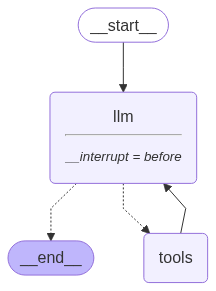

In [12]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1"}}

In [14]:
for event in graph_builder.stream({"messages":HumanMessage(content="Add 2 and 3")},config,stream_mode="values"):
  pprint.pprint(event['messages'])

[HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='224629f9-c0a3-4285-9391-22208aeaaeae')]


In [15]:
res_state = graph_builder.get_state(config)

In [16]:
res_state.next

('llm',)

In [17]:
graph_builder.get_state_history(config)

<generator object Pregel.get_state_history at 0x7971ec5add20>

In [18]:
for ev in graph_builder.stream(None, config, stream_mode="values"):
    ev["messages"][-1].pretty_print()


================================ Human Message =================================

Add 2 and 3
================================== Ai Message ==================================

I'll add 2 and 3 for you.
Tool Calls:
  sum_two_number (functions.sum_two_number:0)
 Call ID: functions.sum_two_number:0
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: sum_two_number

5


edit human feedback

In [19]:
config = {"configurable": {"thread_id": "hunan_in_loop_1"}}

In [20]:
for event in graph_builder.stream({"messages":HumanMessage(content="Add 2 and 3")},config,stream_mode="values"):
  pprint.pprint(event['messages'])

[HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='5291120a-1f8a-4742-b1ee-b22438950297')]


In [21]:
graph_builder.update_state(config,{"messages":[HumanMessage(content="Subract 3 and 2")]})

{'configurable': {'thread_id': 'hunan_in_loop_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0705f7-f763-68ca-8001-cce0055b74d1'}}

In [22]:
graph_builder.get_state(config).values

{'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='5291120a-1f8a-4742-b1ee-b22438950297'),
  HumanMessage(content='Subract 3 and 2', additional_kwargs={}, response_metadata={}, id='2376874f-7bd9-405e-9f43-2e94afa08708')]}

In [23]:
for ev in graph_builder.stream(None, config, stream_mode="values"):
    ev["messages"][-1].pretty_print()

================================ Human Message =================================

Subract 3 and 2
================================== Ai Message ==================================
Tool Calls:
  subract_two_number (functions.subract_two_number:0)
 Call ID: functions.subract_two_number:0
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: subract_two_number

1


With User input

In [26]:
config = {"configurable": {"thread_id": "human_in_loop_with_user_input"}}

In [39]:
graph_builder.invoke({"messages":[HumanMessage(content="Add 2 and 3")]},config)
user_input= input("Tell me what to do")
graph_builder.update_state(config,{"messages":[HumanMessage(content=user_input)]})
res = graph_builder.invoke(config=config,input=None)

Tell me what to doadd 2 and 3


In [37]:
res

{'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='5ab7aba0-2aac-4e47-a125-308eb48cf0a4'),
  HumanMessage(content='add 500 and 1000', additional_kwargs={}, response_metadata={}, id='e353df8a-a4c2-45b0-a14e-a1f6e28d3061'),
  HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='b028d69f-377d-4cf6-a30d-e53cd6d27061'),
  HumanMessage(content='add 500 and 1000', additional_kwargs={}, response_metadata={}, id='e67fe99c-1c49-47d0-8650-1687bbf7a32e'),
  HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='a7ac2c7f-fcd6-4935-beb1-1292ecf346ca'),
  HumanMessage(content='Add 500 and 1000', additional_kwargs={}, response_metadata={}, id='07eb117d-b4ee-42ee-ade4-a9c5920dd919'),
  AIMessage(content='I will add 500 and 1000 for you.', additional_kwargs={'tool_calls': [{'id': 'functions.sum_two_number:0', 'function': {'arguments': '{"a":500,"b":1000}', 'name': 'sum_two_number'}, 'type': 'functi